## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [36]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [37]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"




x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data
There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?
3. What about the performances of NNMF, i.e. computational time and classification accuracy ? Is it better or worse than the other methods ? Why ?
4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

2. On peut remarquer que les images de base obtenues avec NNMF sont plus réalisteq que celles obtenues avec PCA et ICA, les vecteurs/images de base sont plus semblables à des visages. 
3. Les performances de NNMF sont : une classification plus précise et un temps de calcul plus long. Donc il s'agit encore un compromis à faire entre la précision et le temps de calcul. 
4. Il n'est pas judicieux d'utiliser le PCA avant d'utiliser un algorithme de NMF car avec un PCA en amont, l'image en entrée de NNMF n'est plus une image réelle donc l'avantage de l'interprétabilité des résultats en sortie de NNMF est perdue. 

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8737060041407867


/Users/lauriasun/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


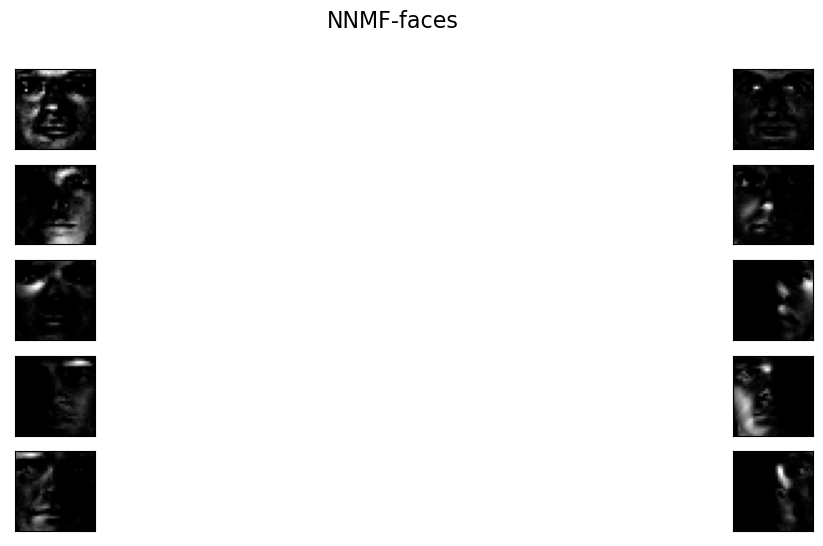

In [3]:
# NNMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [4]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    W=np.ones((d,r))
    H=np.random.random((r,N))   
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
            W = np.divide(W*(X@H.T), W@H@H.T + eps)
                       
        H = np.divide(H * (W.T@X), W.T@W@H + eps)

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

Iteration NNMF number  1  out of  300 , delta =  0.5305474029271453 , error (norm delta):  273.1029244984608
Iteration NNMF number  100  out of  300 , delta =  0.1578433318118982 , error (norm delta):  81.25094061826903
Iteration NNMF number  200  out of  300 , delta =  0.15040188672519256 , error (norm delta):  77.42040558132138
Iteration NNMF number  300  out of  300 , delta =  0.14793568323546377 , error (norm delta):  76.15091037365993
Maximum number of iterations reached ! delta =  0.14793568323546377


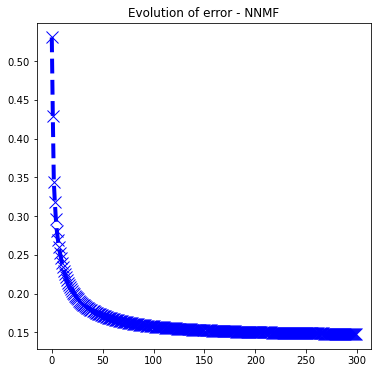

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8737060041407867


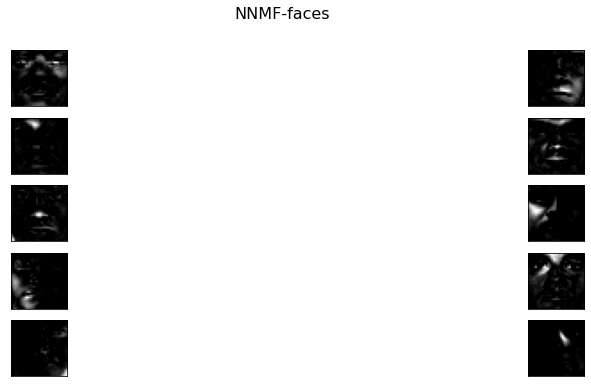

In [5]:
# NNMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(XXXXXXXX,Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

- What do you observe?
- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?

L'inversion de Htest_nnmf pour obtenir une estimation de l'image originale peut être difficile en raison des contraintes non négatives des matrices. Une façon d'éviter cette limitation est d'utiliser une technique de régularisation qui ajoute un terme de pénalité à la fonction objectif de la NNMF pour s'assurer que la matrice de coefficients H résultante est plus facile à inverser. 

## I-3) ICA and NNMF in the presence of noise

We will now compare ICA and NNMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.
2. On the other hand, do you think that NNMF behaves better? If so, for what kind of noises?

In the following, we will try to compare the behavior of ICA and NNMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NNMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NNMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NNMF are used as pre-processing steps. Comment your results.

1. ICA ne fonctionnerait pas bien en présence de bruit. En présence d'un bruit gaussien, l'ICA peut ne pas donner de bons résultats car le bruit peut contaminer le signal et provoquer des interférences dans le processus de séparation. En effet, l'ICA est basée sur l'hypothèse que les signaux sont indépendants, ce qui peut ne pas être vrai en présence de bruit. 


2. D'autre part, la factorisation matricielle non négative (NNMF) est une technique qui s'est avérée robuste au bruit gaussien dans certains cas. En effet, la NNMF est basée sur la factorisation non négative de la matrice de données en une matrice de base et une matrice de coefficients, ce qui peut être plus robuste au bruit que l'ICA.  La NNMF est capable de bien séparer bruit et signal avec un bruit clairsemé, mais pas avec le bruit fortement corrélé avec le signal.

Mon code ne converge pas, je n'ai pas trouvé l'erreur.

In [62]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
#sigmaTab = np.array([0])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    print("iteration",i,"over",len(sigmaTab))
    # Data generation
    XtrainNoise = Xctrain + np.random.normal(0,sigmaTab[i],size=Xctrain.shape)
    XtestNoise = Xctest + np.random.normal(0,sigmaTab[i],size=Xctest.shape)
    
    XtrainNoise = (XtrainNoise - np.min(XtrainNoise)) / (np.max(XtrainNoise) - np.min(XtrainNoise))
    XtestNoise = (XtestNoise - np.min(XtestNoise)) / (np.max(XtestNoise) - np.min(XtestNoise))

    XctrainNoise = XtrainNoise - XtrainNoise.mean(axis=0) 
    XctestNoise = XtestNoise - XtestNoise.mean(axis=0) 
    
    ##################
    # NMF
    Ncomponents=250
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')
    
    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(HtrainNNMF.T,Id_Train.ravel())
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T,Id_Test)

    ##################
    ## ICA
    # Second architecture (scikit-learn implementation)
    ICA= FastICA(n_components=Ncomponents,whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
    YtrainICA=ICA.fit_transform(XctrainNoise)
    WtrainICA=ICA.mixing_
    #...
    YtestICA = ICA.transform(XctestNoise)
    Stest = WtrainICA @ YtestICA.T
    Strain = WtrainICA @ YtrainICA.T
    NN.fit(Strain.T,Id_Train.ravel())
    print('Percentage of correct answer using ICA is ', NN.score(Stest.T,Id_Test.ravel()))
    scoreICA[i] = NN.score(Stest.T,Id_Test.ravel())

iteration 0 over 9


/Users/lauriasun/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.9047619047619048


/Users/lauriasun/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/lauriasun/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

KeyboardInterrupt: 

In [ ]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [41]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

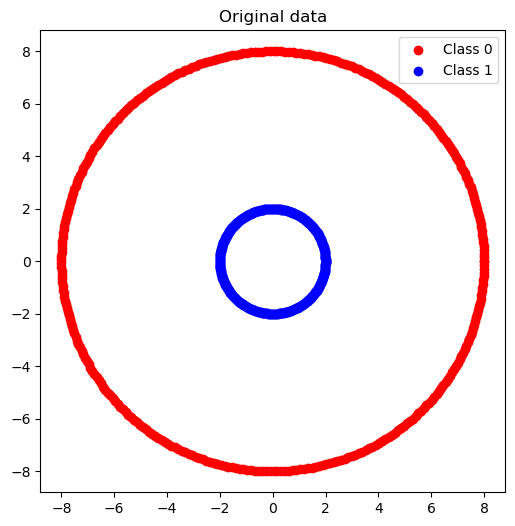

In [42]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

1. K-means ne marche pas bien dans tous les scénarios, en partculier si les données se croisent.  En effet, l'algorithme cherche à minimiser une distance aux centroïdes qui sera identique quelle que soit la classe réelle du point. Il n'est pas facile de toujours définir le bon nombre de clusters si on ne connait pas les données initialement. 

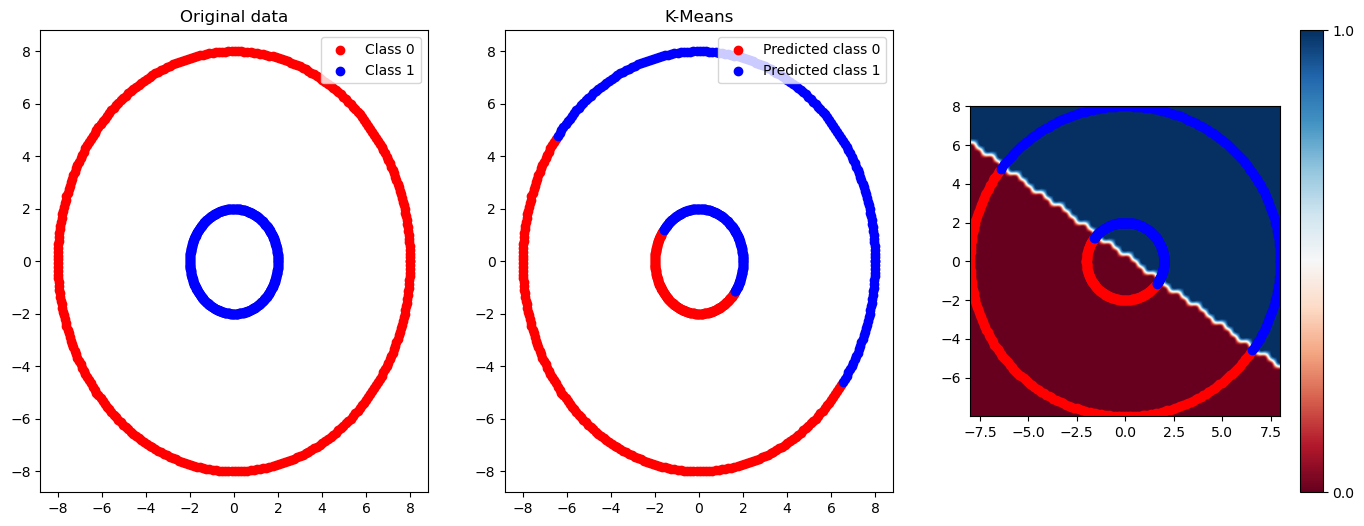

In [43]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

Now, implement your own K-means using the Lloyd's algorithm.

In [44]:
def KMeansLecture(X,K=2,tol=1e-4):

    # Initialize the centroids randomly
    muTab = X[np.random.choice(len(X), K, replace=False), :]
    
    err = np.inf
    
    while err > tol:
        # Assign each point to the closest centroid
        yKmeans = np.argmin(np.linalg.norm(X[:, None] - muTab, axis=2), axis=1)
        
        # Update the centroids to the mean of the assigned points
        mu_new = np.array([np.mean(X[yKmeans == k, :], axis=0) for k in range(K)])
        
        # Compute the error as the distance between the old and new centroids
        err = np.linalg.norm(mu_new - muTab)
        
        # Update the centroids
        muTab = mu_new
    
    # Return the assignments and centroids
    return yKmeans,muTab


Now, test your K-means algorithm.

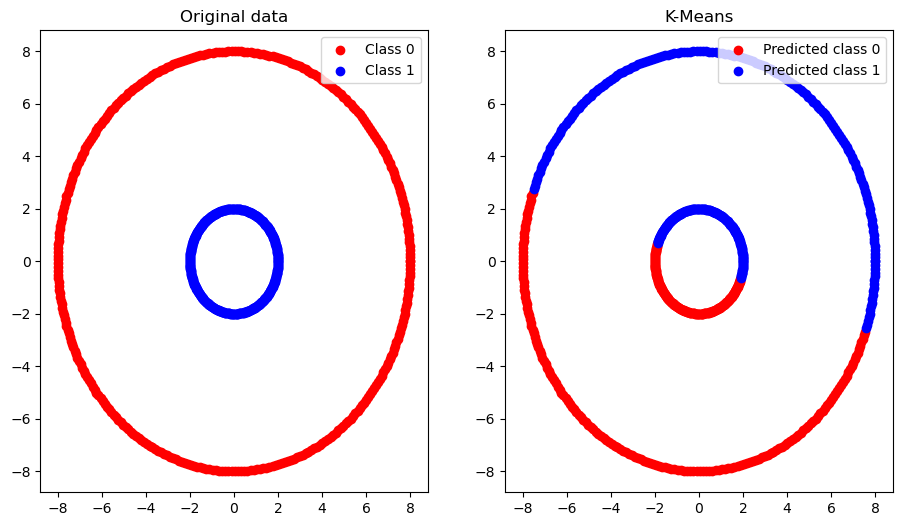

In [63]:
## K-means
Ncluster= 2 # choose a number of clusters
yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


/var/folders/0f/xr7tmt4j36s_824n5z1c8bw80000gn/T/ipykernel_72456/2387266696.py:26: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
/var/folders/0f/xr7tmt4j36s_824n5z1c8bw80000gn/T/ipykernel_72456/2387266696.py:37: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)


(-0.5, 374.5, 280.5, -0.5)

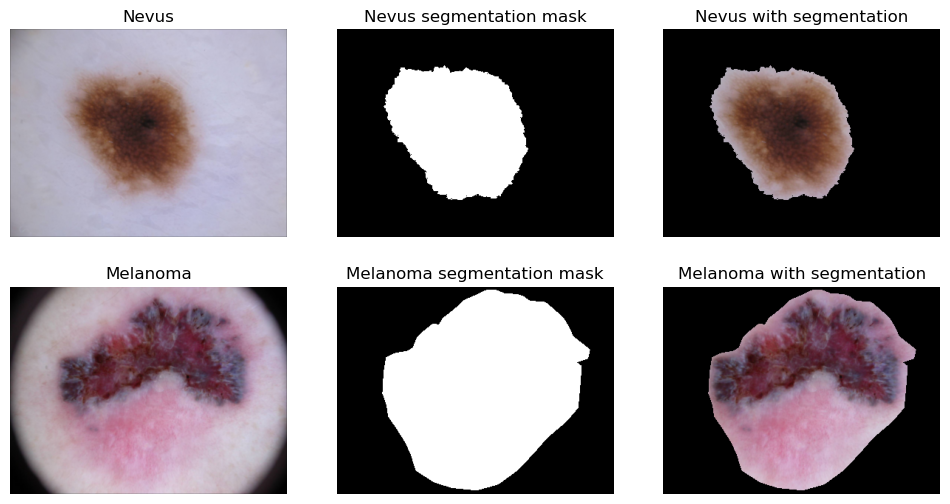

In [46]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./" 




# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpeg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. Propose a way to automatically select the class (or unions of classes) representing the skin lesion and not the skin. (You don't need to implement it, just explain how you would do it).

4. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

1. Je pense qu'utiliser K=2 serait adapté à cette situation. En effet, ce qui nous intéresse ici c'est de détecter la lésion de la peau donc il devrait y avoir la lésion et le reste de la peau, qui est saine. Cependant, ce n'est pas possible pour toutes les images. En effet, on peut distinguer 3 zones sur le deuxième mélanome, la peau saine, la peau rouge et la lésion en elle-même donc il sera nécessaire d'utiliser un K différent en fonction de l'image. 

2. Pour le grain de beauté, on constate qu'on a les meilleurs résultats avec 2 cluster sur la channel bleu. Et pour le mélanome le meilleur résultat est avec le channel vert et 2 clusters.

3. On constaque que la lésion se situe toujours au centre. On pourrait par exemple définir une zone centrale, à l'intérieur de laquelle on déterminerait la classe majoritaire, considérant qu'elle correspond à la lésion. Si la lésion est composée de plusieurs classes, il faudra alors fusionner les régions. On peut estimer que deux clusters correspondent à la même zone si leur intensité moyenne est suffisamment proche.

4. Pour contraindre la moyenne à toujours être l'une des observations originales, nous pouvons modifier l'algorithme de Lloyd en appliquant explicitement la contrainte selon laquelle les centres doivent être choisis parmi les points de données originaux. 

The dice score is  0.8298660203325927


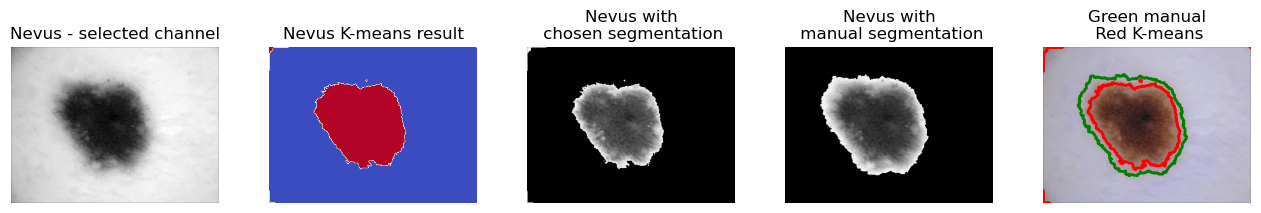

In [60]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.flatten(), mask.flatten()))

The dice score is  0.5041915349218643


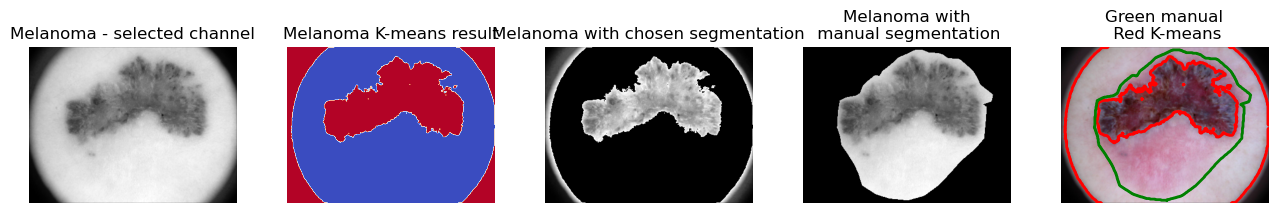

In [61]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1
##
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(melanomaMask_boolean.flatten(), mask.flatten()))